# A Linear Regression Example
## - Generate training data

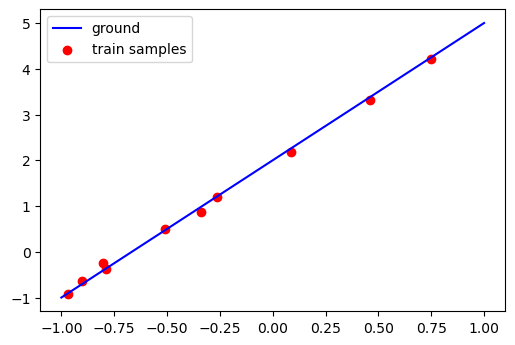

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from misc import *

import torch.nn as nn
import torch.optim as optim

from tqdm.auto import tqdm, trange

device = torch.device('cuda:0')

torch.manual_seed(222)
np.random.seed(333)


def ground(x):
    y = 3*x + 2
    return y
    
Ntr = 10
noise = 1e-1
    
Xtr = np.random.uniform(-1,1, size=[Ntr,1])
ytr = ground(Xtr)
epsi = noise*np.random.normal(size=ytr.shape)

ytr = ytr+epsi

Xte = np.linspace(-1,1,100).reshape([-1,1])
yte = ground(Xte)

fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(Xte.squeeze(), yte.squeeze(), color='b', label='ground')
plt.scatter(Xtr.squeeze(), ytr.squeeze(), color='r', label='train samples')
plt.legend()


## - Put the numpy nparray into torch Dataset

In [2]:

class SimpleDataset(Dataset):
    def __init__(self, X, y):
        super(SimpleDataset, self).__init__()
        self.X = X
        self.y = y
        
    def __getitem__(self, index):
        return self.X[index,:], self.y[index,:]

    def __len__(self,):
        return self.X.shape[0]
        
dataset_train = SimpleDataset(Xtr, ytr)
dataset_test = SimpleDataset(Xte, yte)


## - Implement a linear regressor with nn.Module with built-in nn modules 

In [3]:

class LinearRegressor(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(LinearRegressor, self).__init__()  
        self.linear = nn.Linear(in_features=in_dim, out_features=out_dim)
    
    def forward(self, X):
        return self.linear(X)

# instantiate a linear regressor and send to it device
model = LinearRegressor(in_dim=1, out_dim=1).to(device)

# create dataloaders for training and testing
train_loader = DataLoader(dataset_train, batch_size=len(dataset_train), shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

# training hypyterparameters
epochs=1000
lr=1e-2
reg=1e-5

# instantiate optimizer and pass model's internal differentiable parameters
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

hist_rmse_tr = []
hist_rmse_te = []
hist_pred_te = []

# Train
for ie in tqdm(range(epochs+1)):
    
    Xtr, ytr = next(iter(train_loader))
    Xte, yte = next(iter(test_loader))
    
    Xtr, ytr, Xte, yte = \
        Xtr.float().to(device), ytr.float().to(device), Xte.float().to(device), yte.float().to(device)
    
    pred = model(Xtr)
    loss = torch.mean(torch.square(pred-ytr))
    
    # step 1: clear the grads
    optimizer.zero_grad()
    # step 2: backward the computational graph
    loss.backward()
    # step 3: take the gradient step
    optimizer.step()
    
    if ie%50 == 0:
        cprint('r', 'Epoch #{}\t: '.format(ie), end='')
        with torch.no_grad():
            rmse_tr = torch.sqrt(torch.mean(torch.square(ytr-pred)))
            rmse_te = torch.sqrt(torch.mean(torch.square(yte-model(Xte))))
            print('train_rmse={:.5f}, test_rmse={:.5f}'.format(rmse_tr.item(), rmse_te.item()))
            
            hist_rmse_tr.append(rmse_tr.item())
            hist_rmse_te.append(rmse_te.item())
            hist_pred_te.append(model(Xte).data.cpu().numpy())
        #
    #
#

hist_rmse_tr = np.array(hist_rmse_tr)
hist_rmse_te = np.array(hist_rmse_te)
hist_pred_te = np.array(hist_pred_te)        

  0%|          | 0/1001 [00:00<?, ?it/s]

Epoch #0	: train_rmse=1.99599, test_rmse=2.71404
Epoch #50	: train_rmse=1.57545, test_rmse=2.15471
Epoch #100	: train_rmse=1.20535, test_rmse=1.65973
Epoch #150	: train_rmse=0.89367, test_rmse=1.24089
Epoch #200	: train_rmse=0.64015, test_rmse=0.89913
Epoch #250	: train_rmse=0.44319, test_rmse=0.63242
Epoch #300	: train_rmse=0.29710, test_rmse=0.43200
Epoch #350	: train_rmse=0.19585, test_rmse=0.28965
Epoch #400	: train_rmse=0.13098, test_rmse=0.19333
Epoch #450	: train_rmse=0.09492, test_rmse=0.13154
Epoch #500	: train_rmse=0.07863, test_rmse=0.09364
Epoch #550	: train_rmse=0.07268, test_rmse=0.07101
Epoch #600	: train_rmse=0.07079, test_rmse=0.05956
Epoch #650	: train_rmse=0.07027, test_rmse=0.05282
Epoch #700	: train_rmse=0.07014, test_rmse=0.04944
Epoch #750	: train_rmse=0.07012, test_rmse=0.04777
Epoch #800	: train_rmse=0.07011, test_rmse=0.04745
Epoch #850	: train_rmse=0.07011, test_rmse=0.04735
Epoch #900	: train_rmse=0.07012, test_rmse=0.04633
Epoch #950	: train_rmse=0.07012, t

## - Plot the training and testing loss history

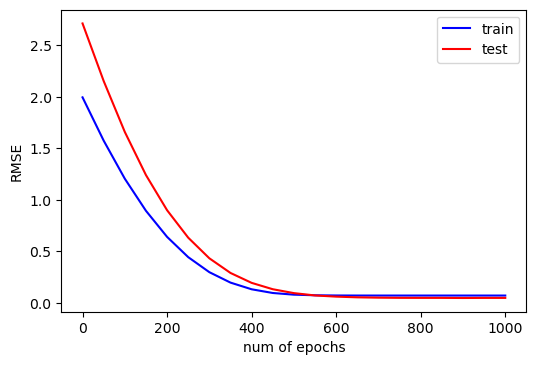

In [4]:
fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')
hist = np.arange(hist_rmse_tr.size)*50

plt.plot(hist, hist_rmse_tr, color='b', label='train')
plt.plot(hist, hist_rmse_te, color='r', label='test')
plt.xlabel('num of epochs')
plt.ylabel('RMSE')
plt.legend()

## - Visualize the trained regressor

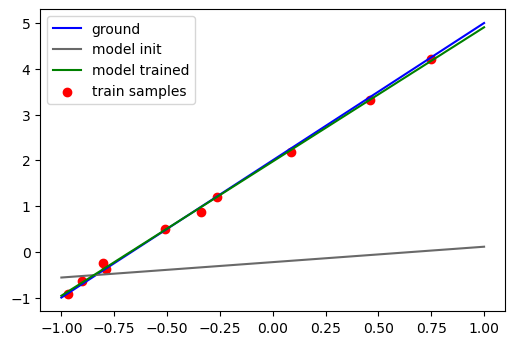

In [5]:
fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(Xte.cpu().squeeze(), yte.cpu().squeeze(), color='b', label='ground')
plt.scatter(Xtr.cpu().squeeze(), ytr.cpu().squeeze(), color='r', label='train samples')
plt.plot(Xte.cpu().squeeze(), hist_pred_te[0,:].squeeze(), color='dimgray', label='model init')
plt.plot(Xte.cpu().squeeze(), hist_pred_te[-1,:].squeeze(), color='green', label='model trained')
plt.legend()

# A more challenging example with NN
## - Generate training and testing data

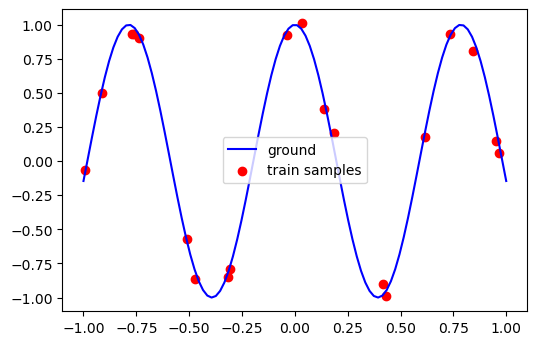

In [6]:
def sinuous(x):
    y = np.sin(8*x+0.5*np.pi)
    return y
    
Ntr = 20
noise = 5e-2
    
Xtr = np.random.uniform(-1,1, size=[Ntr,1])
ytr = sinuous(Xtr)
epsi = noise*np.random.normal(size=ytr.shape)

ytr = ytr+epsi

Xte = np.linspace(-1,1,100).reshape([-1,1])
yte = sinuous(Xte)

fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(Xte.squeeze(), yte.squeeze(), color='b', label='ground')
plt.scatter(Xtr.squeeze(), ytr.squeeze(), color='r', label='train samples')
plt.legend()

dataset_train = SimpleDataset(Xtr, ytr)
dataset_test = SimpleDataset(Xte, yte)

## - Initialize a NN with nn.module

In [7]:
class Net(nn.Module):
    def __init__(self, config, act=nn.Tanh()):
        
        super(Net, self).__init__()
 
        layers_list = []

        for l in range(len(config)-2):
            in_dim = config[l]
            out_dim = config[l+1]
            
            layers_list.append(nn.Linear(in_features=in_dim, out_features=out_dim))
            layers_list.append(nn.Tanh())
            
        #
        
        # last layer
        layers_list.append(nn.Linear(in_features=config[-2], out_features=config[-1]))
        
        # containers: https://pytorch.org/docs/stable/nn.html#containers
        self.net = nn.ModuleList(layers_list)
        
    def forward(self, X):
        h = X
        for layer in self.net:
            h = layer(h)
        #
        return h


config = [1, 64, 64, 1]

model = Net(config).to(device)

num_params = sum(p.numel() for p in model.parameters())
print(model)
cprint('r', 'Total params: {:.3f}K'.format(num_params/(1e3)))



Net(
  (net): ModuleList(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)
Total params: 4.353K


## Train

In [8]:
train_loader = DataLoader(dataset_train, batch_size=len(dataset_train), shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

epochs=5000
lr=1e-3
reg=1e-5

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

hist_rmse_tr = []
hist_rmse_te = []
hist_pred_te = []

for ie in tqdm(range(epochs+1)):
    
    Xtr, ytr = next(iter(train_loader))
    Xte, yte = next(iter(test_loader))
    
    Xtr, ytr, Xte, yte = \
        Xtr.float().to(device), ytr.float().to(device), Xte.float().to(device), yte.float().to(device)
    
    pred = model(Xtr)
    loss = torch.mean(torch.square(pred-ytr))
    

    # step 1: clear the grads
    optimizer.zero_grad()
    # step 2: backward the computational graph
    loss.backward()
    # step 3: take the gradient step
    optimizer.step()
    
    if ie%500 == 0:
        cprint('r', 'Epoch #{}\t: '.format(ie), end='')
        with torch.no_grad():
            rmse_tr = torch.sqrt(torch.mean(torch.square(ytr-pred)))
            rmse_te = torch.sqrt(torch.mean(torch.square(yte-model(Xte))))
            print('train_rmse={:.5f}, test_rmse={:.5f}'.format(rmse_tr.item(), rmse_te.item()))
            
            hist_rmse_tr.append(rmse_tr.item())
            hist_rmse_te.append(rmse_te.item())
            hist_pred_te.append(model(Xte).data.cpu().numpy())
        #
    #


hist_rmse_tr = np.array(hist_rmse_tr)
hist_rmse_te = np.array(hist_rmse_te)
hist_pred_te = np.array(hist_pred_te)

# You can saved the 
create_path('__chkp__')
torch.save(model.state_dict(), os.path.join('__chkp__', 'pretrained.dict')) 


  0%|          | 0/5001 [00:00<?, ?it/s]

Epoch #0	: train_rmse=0.80198, test_rmse=0.71983
Epoch #500	: train_rmse=0.24114, test_rmse=0.25123
Epoch #1000	: train_rmse=0.02311, test_rmse=0.15769
Epoch #1500	: train_rmse=0.01192, test_rmse=0.17699
Epoch #2000	: train_rmse=0.00960, test_rmse=0.18782
Epoch #2500	: train_rmse=0.00733, test_rmse=0.19647
Epoch #3000	: train_rmse=0.00815, test_rmse=0.20148
Epoch #3500	: train_rmse=0.00676, test_rmse=0.20176
Epoch #4000	: train_rmse=0.00435, test_rmse=0.19659
Epoch #4500	: train_rmse=0.00550, test_rmse=0.19281
Epoch #5000	: train_rmse=0.00872, test_rmse=0.19209
Directory '__chkp__' created successfully


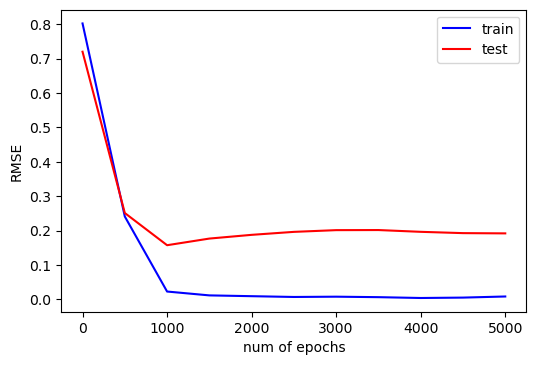

In [9]:
fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')
hist = np.arange(hist_rmse_tr.size)*500

plt.plot(hist, hist_rmse_tr, color='b', label='train')
plt.plot(hist, hist_rmse_te, color='r', label='test')
plt.xlabel('num of epochs')
plt.ylabel('RMSE')
plt.legend()

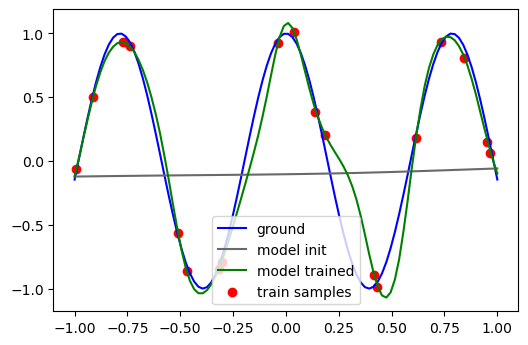

In [10]:
fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(Xte.cpu().squeeze(), yte.cpu().squeeze(), color='b', label='ground')
plt.scatter(Xtr.cpu().squeeze(), ytr.cpu().squeeze(), color='r', label='train samples')
plt.plot(Xte.cpu().squeeze(), hist_pred_te[0,:].squeeze(), color='dimgray', label='model init')
plt.plot(Xte.cpu().squeeze(), hist_pred_te[-1,:].squeeze(), color='green', label='model trained')
plt.legend()

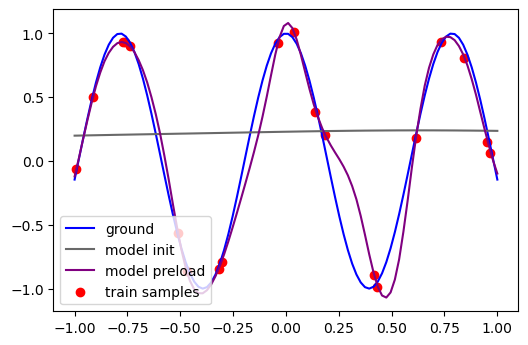

In [11]:

config = [1, 64, 64, 1]
new_model = Net(config).to(device)

Xtr, ytr = next(iter(train_loader))
Xte, yte = next(iter(test_loader))

Xtr, ytr, Xte, yte = \
    Xtr.float().to(device), ytr.float().to(device), Xte.float().to(device), yte.float().to(device)

with torch.no_grad():
    pred_before = new_model(Xte)
    
new_model.load_state_dict(torch.load(os.path.join('__chkp__', 'pretrained.dict')))

with torch.no_grad():
    pred_after = new_model(Xte)

fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(Xte.cpu().squeeze(), yte.cpu().squeeze(), color='b', label='ground')
plt.scatter(Xtr.cpu().squeeze(), ytr.cpu().squeeze(), color='r', label='train samples')
plt.plot(Xte.cpu().squeeze(), pred_before.cpu().squeeze(), color='dimgray', label='model init')
plt.plot(Xte.cpu().squeeze(), pred_after.cpu().squeeze(), color='purple', label='model preload')
plt.legend()

